In [104]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
from scipy.signal import savgol_filter, peak_widths, find_peaks, peak_prominences
#import celerite
#from celerite import terms

### 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

Metadata

In [3]:
import pandas as pd

filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [4]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

Download light curve from MAST

In [5]:
flc = lightkurve.search_lightcurve("EPIC 246301900", cadence="long", campaign=12, mission="K2")
print(flc)

SearchResult containing 3 data products.

 #     mission     year  author exptime  target_name  distance
                                   s                   arcsec 
--- -------------- ---- ------- ------- ------------- --------
  0 K2 Campaign 12 2016      K2    1800 ktwo246301900      0.0
  1 K2 Campaign 12 2016 EVEREST    1800 ktwo246301900      0.0
  2 K2 Campaign 12 2016   K2SFF    1800 ktwo246301900      0.0


In [6]:
download = flc[2].download()

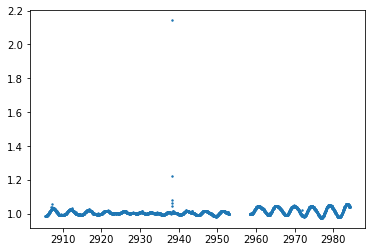

In [7]:
plt.scatter(download.time.value, download.flux.value, s=2)
plt.show()

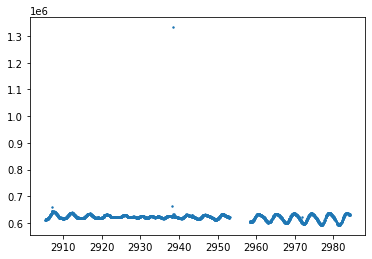

In [8]:
plt.scatter(df.TIME, df.PDCSAP_FLUX, s=2)
plt.show()

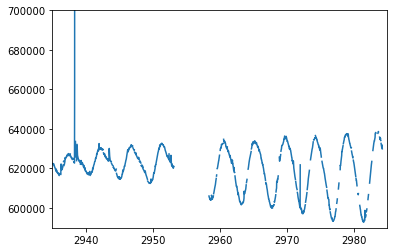

In [9]:
# examine the gap
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2935,2985])
plt.ylim([590000,700000])
plt.show()

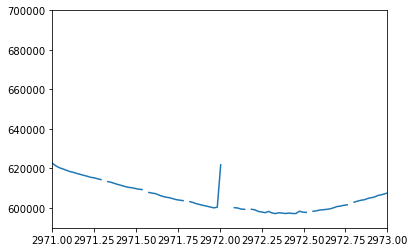

3256    601289.4375
3257    600915.5625
3258    600486.1250
3259    600089.1250
3260    600415.0000
3261    621832.1875
3262            NaN
3263            NaN
3264            NaN
3265    600196.0000
Name: PDCSAP_FLUX, dtype: float32


In [10]:
# examine spike/possible flare shortly after 2970 BJD
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2971,2973])
plt.ylim([590000,700000])
plt.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)

3255


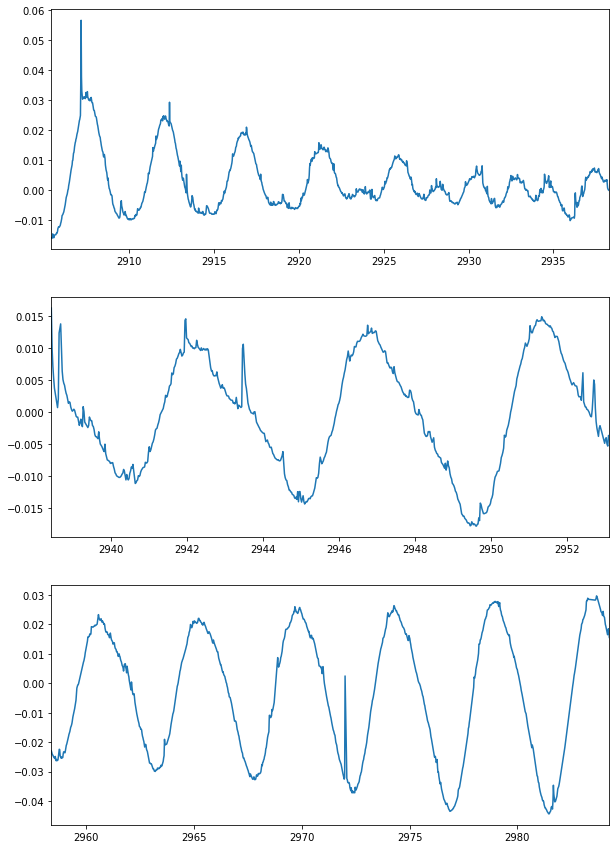

In [11]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) GP Modeling

Model with GP in order to get a baby-smooth light curve on which I can inject artificial flares for injection recovery.

Pre-super-flare

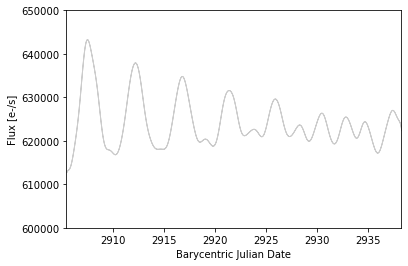

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612843.0178797  612963.33290786 613059.09891857 ... 623112.17550293
 622799.29855908 622437.74863554]


In [12]:
lhs_pre = min(pre.TIME)
rhs_pre = max(pre.TIME)
xobs_pre = np.array(pre["TIME"])
yobs_pre = np.array(pre["PDCSAP_FLUX"])
eobs_pre = np.array(pre["PDCSAP_FLUX_ERR"])

kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.8)
gp_pre = george.GP(kernel_pre)
gp_pre.compute(xobs_pre, eobs_pre)

pred_pre, pred_var_pre = gp_pre.predict(yobs_pre, xobs_pre, return_var=True)

plt.fill_between(xobs_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre),
                color="k", alpha=0.2)
#plt.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
plt.xlim(lhs_pre, rhs_pre)
#plt.xlim(lhs,2910)
plt.ylim(600000,650000)
plt.xlabel(r'Barycentric Julian Date')
plt.ylabel(r'Flux [e-/s]')
#plt.scatter(xobs_pre, yobs_pre, s=2)
plt.show()

print(yobs_pre)
print(pred_pre)

Same for post and postgap

In [13]:
def alias(df, normalized_flag, method, segment):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    - method: 'gp' or 'savgol'
    - segment: 'pre', 'post', or 'postgap' (really only needed for savgol)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["PDCSAP_FLUX"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.5) # 0.8
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        if method=='gp':
            pred, pred_var = gp.predict(yobs, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs, 129, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs, 129, polyorder=3)
            return pred
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        if method=='gp':
            pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
            return pred, pred_var
        elif method=='savgol':
            if segment=='pre':
                pred = savgol_filter(yobs_norm, 109, polyorder=3)
            elif segment=='post':
                pred = savgol_filter(yobs_norm, 149, polyorder=3)
            elif segment=='postgap':
                pred = savgol_filter(yobs_norm, 129, polyorder=3)
            return pred

#pred_pre, pred_var_pre = alias(pre, normalized_flag=True, method='gp', segment='pre')
#pred_post, pred_var_post = alias(post, normalized_flag=True, method='gp', segment='post')
pred_pre = alias(pre, normalized_flag=True, method='savgol', segment='pre')
pred_post = alias(post, normalized_flag=True, method='savgol', segment='post')
pred_postgap, pred_var_postgap = alias(postgap, normalized_flag=True, method='gp', segment='postgap')


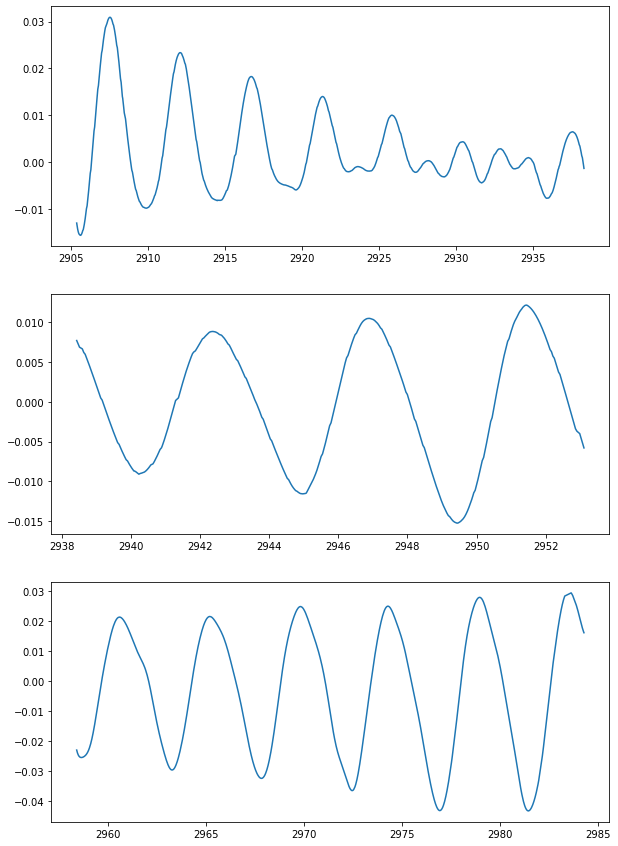

In [14]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, pred_pre)

plt.subplot(312)
plt.plot(post.TIME, pred_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

### 3) Inject flares

Pieces taken from Ekaterina Ilin's Altaipony: https://github.com/ekaterinailin/AltaiPony/blob/037bd76c8ed09ed6340cf2105d1e83bc302168eb/altaipony/flarelc.py

In [15]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    #error = error # pred_var_pre
    flux = flux # pred_pre
    time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed)
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

dur_fake_pre, ampl_fake_pre, t0_fake_pre, ed_fake_pre, flux_pre = inject_fakes(pred_pre, pre, num_flares=20)
dur_fake_post, ampl_fake_post, t0_fake_post, ed_fake_post, flux_post = inject_fakes(pred_post, post, num_flares=10)
dur_fake_postgap, ampl_fake_postgap, t0_fake_postgap, ed_fake_postgap, flux_postgap = inject_fakes(pred_postgap, postgap, num_flares=20)


In [16]:
ampl_fake_pre

array([0.57363864, 3.64779751, 2.40744348, 0.4204132 , 3.45637218,
       1.47423116, 1.09149725, 2.80718997, 0.68447711, 4.91122997,
       3.59276579, 2.93231973, 2.91559168, 3.18742961, 3.67476617,
       1.5898957 , 2.24710286, 2.98734143, 3.20201788, 2.12442065])

In [17]:
print(dur_fake_pre)
print(ampl_fake_pre)
print(t0_fake_pre)
print(ed_fake_pre)
print(flux_pre)

[0.00591596 0.00970797 0.00940744 0.00974729 0.01060966 0.0112741
 0.00994025 0.00594789 0.01139517 0.00797798 0.01005789 0.008262
 0.00766012 0.00622462 0.00539317 0.00692975 0.00842741 0.00821778
 0.00517537 0.00607131]
[0.57363864 3.64779751 2.40744348 0.4204132  3.45637218 1.47423116
 1.09149725 2.80718997 0.68447711 4.91122997 3.59276579 2.93231973
 2.91559168 3.18742961 3.67476617 1.5898957  2.24710286 2.98734143
 3.20201788 2.12442065]
[2933.18657419 2914.12026189 2906.65683204 2905.74889641 2917.40554015
 2935.19370684 2920.22996204 2923.5491058  2915.20777788 2920.64943934
 2912.63370128 2921.79067595 2915.15705409 2937.14803982 2922.90499204
 2919.8370792  2923.42949743 2922.30309953 2912.10292083 2911.92805134]
[ 269.64743674 4873.89511873 1388.33750071  166.61811384 2674.45993437
  930.64929661 1756.27815846  542.67153638  523.97475936 1677.9729778
 1789.11766978  835.91098092 1372.93975797 4424.38227765 2464.96945593
  763.82887776  925.85089467  955.46331253  311.8036838 

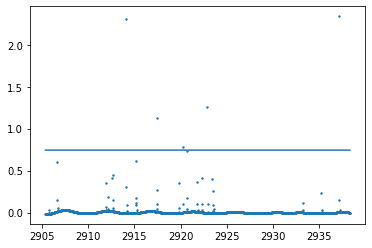

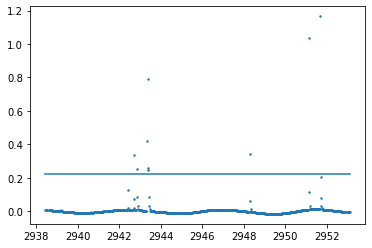

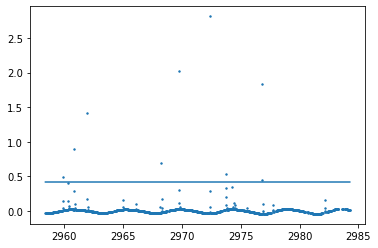

In [18]:
### did I do it?
plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, np.ones(len(pre))*np.median(flux_pre)+7*np.std(flux_pre))
#plt.xlim(2908, 2911)
plt.show()

plt.scatter(post.TIME, flux_post, s=2)
plt.plot(post.TIME, np.ones(len(post))*np.median(flux_post)+3*np.std(flux_post))
plt.show()

plt.scatter(postgap.TIME, flux_postgap, s=2)
plt.plot(postgap.TIME, np.ones(len(postgap))*np.median(flux_postgap)+3*np.std(flux_postgap))
plt.show()
### yes I did!

### 4) Recover fake flares

In [19]:
print(np.abs(flux_pre))
print(np.abs(flux_pre) / np.sqrt(pred_var_pre))
print(np.abs(flux_pre) / pred_var_pre)
print(np.median(flux_pre))
print(np.median(flux_pre)+3*np.std(flux_pre))

[0.01298546 0.0134594  0.01388325 ... 0.00035522 0.00083043 0.00132385]
[9.75379496e-04 1.24952424e-03 1.55732682e-03 ... 3.84930492e-05
 7.47104822e-05 9.66678348e-05]
[7.32639020e-05 1.16001539e-04 1.74690080e-04 ... 4.17128225e-06
 6.72143950e-06 7.05871144e-06]
0.0003716824867296964
0.3193241989488794


In [20]:
flux = flux_pre
var = pred_var_pre
#var = pre.PDCSAP_FLUX_ERR
T0 = flux # excursion should be positive #"N0"
T1 = np.abs(flux) / np.std(flux) #N1
T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
print("T1: ", T1)
print("T2: ", T2)
minsep = 3
N1 = 7
N2 = 3
N3 = 1
istart = np.array([], dtype='int')
istop = np.array([], dtype='int')

pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
print("pass thresholds: ", pass_thresholds)

#array of indices where thresholds are exceeded:
is_pass_thresholds = np.zeros_like(flux)
is_pass_thresholds[pass_thresholds] = 1

# test based on consecutive points
reverse_counts = np.zeros_like(flux, dtype='int')
for k in range(2, len(flux)):
    reverse_counts[-k] = (is_pass_thresholds[-k]
                            * (reverse_counts[-(k-1)]
                            + is_pass_thresholds[-k]))

# find flare start where values in reverse_counts switch from 0 to >=N3
istart_i = np.where((reverse_counts[1:] >= N3) &
                    (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

# use the value of reverse_counts to determine how many points away stop is
istop_i = istart_i + (reverse_counts[istart_i])

# Create boolean flare mask
isflare = np.zeros_like(flux, dtype='bool')

for (l,r) in list(zip(istart_i, istop_i)):
    isflare[l:r+1] = True
    
print("is flare? ", isflare)

### 

# now pick out final flare candidate indices
candidates = np.where( isflare > 0)[0]
print("candidates: ", candidates)
if (len(candidates) < 1): # no candidates = no indices
    istart_gap = np.array([])
    istop_gap = np.array([])
else:
    # find start and stop index, combine neighboring candidates
    # in to same events
    separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
    istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
    istop_gap = candidates[ np.append(separated_candidates,
                            [len(candidates) - 1]) ]

print(istart_gap)
print(istop_gap)
#stitch indices back into the original light curve
#istart = np.array(np.append(istart, istart_gap + le), dtype='int')
#istop = np.array(np.append(istop, istop_gap + le), dtype='int')

print(len(istart_gap))

T1:  [0.12213845 0.12659625 0.13058296 ... 0.00334111 0.00781081 0.01245185]
T2:  [125.34360859 101.4421579   83.98129255 ...  86.80098947 104.55550696
 128.82310571]
pass thresholds:  (array([ 399,  552,  687,  811, 1458]),)
is flare?  [False False False ... False False False]
candidates:  [ 399  400  552  553  687  688  811  812 1458 1459]
[ 399  552  687  811 1458]
[ 400  553  688  812 1459]
5


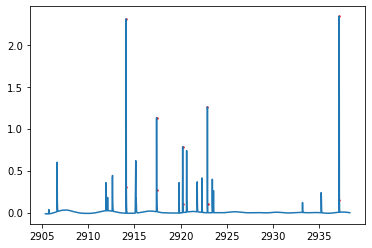

In [21]:
#for xc in pre.TIME[istart_gap]:
#    plt.axvline(x=xc, c='r')
#for xc in t0_fake_pre:
#    plt.axvline(x=xc, c='r', linestyle='--')
#plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, flux_pre)
#plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

### 5) Evaluate recovery

Compare istart_gaps and t0s to calculate TPs, FPs, and FNs. 

In [22]:
print(istart_gap)
print(np.array(pre.TIME)[istart_gap])

[ 399  552  687  811 1458]
[2914.12220034 2917.41175589 2920.23136518 2922.9079429  2937.14886428]


In [23]:
t0_fake_pre

array([2933.18657419, 2914.12026189, 2906.65683204, 2905.74889641,
       2917.40554015, 2935.19370684, 2920.22996204, 2923.5491058 ,
       2915.20777788, 2920.64943934, 2912.63370128, 2921.79067595,
       2915.15705409, 2937.14803982, 2922.90499204, 2919.8370792 ,
       2923.42949743, 2922.30309953, 2912.10292083, 2911.92805134])

In [24]:
pred_flares_pre = pd.DataFrame({'istart': np.array(pre.TIME)[istart_gap], 
                                'istop': np.array(pre.TIME)[istop_gap],
                               'gap': np.array(pre.TIME)[istop_gap]-np.array(pre.TIME)[istart_gap]})
print(pred_flares_pre)

tps = 0
for i in t0_fake_pre:
    # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
    if (np.abs(i - pred_flares_pre['istart']) < np.max(pred_flares_pre['gap'])).any():
        tps += 1
fps = len(istart_gap) - tps      
fns = len(t0_fake_pre) - tps
print("TPs: ", tps)
print("FPs: ", fps)
print("FNs: ", fns)

        istart        istop       gap
0  2914.122200  2914.142632  0.020432
1  2917.411756  2917.432188  0.020432
2  2920.231365  2920.251797  0.020432
3  2922.907943  2922.928375  0.020432
4  2937.148864  2937.169296  0.020432
TPs:  5
FPs:  0
FNs:  15


In [25]:
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)))
print(np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR))
print(np.std(pre.PDCSAP_FLUX))
print(np.median(pre.PDCSAP_FLUX))
print(pred_pre)
print(pred_var_pre)

1        9925.3750
2        9947.8125
3       10015.8125
4        9865.2500
5        9091.9375
           ...    
1607      292.0625
1608       66.0000
1609       70.1250
1610       30.4375
1611       96.1875
Name: PDCSAP_FLUX, Length: 1511, dtype: float32
1        9947.728516
2        9970.178711
3       10038.190430
4        9887.641602
5        9114.365234
            ...     
1607      269.120148
1608       43.062344
1609       47.187157
1610       53.378136
1611      119.137451
Length: 1511, dtype: float32
5889.1313
622840.6
[-0.01298546 -0.0134594  -0.01388325 ... -0.00035522 -0.00083043
 -0.00132385]
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]


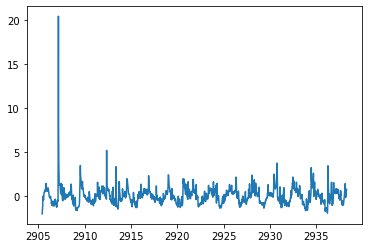

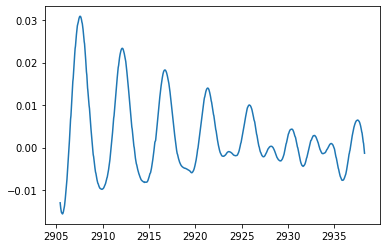

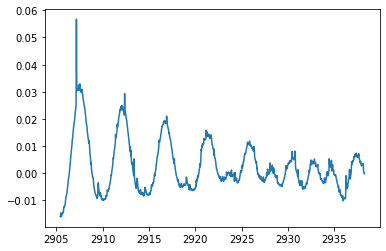

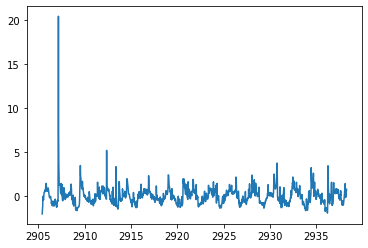

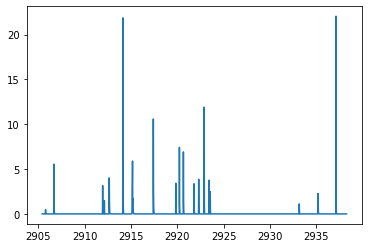

22.038738956217372


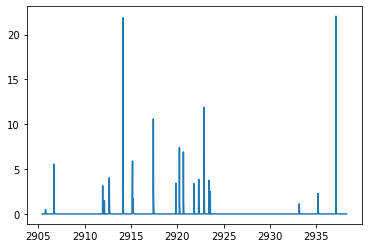

22.038390950841514


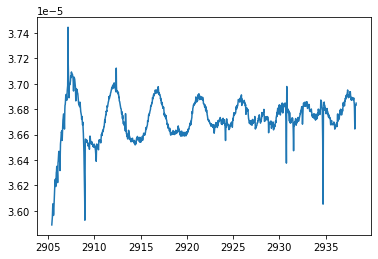

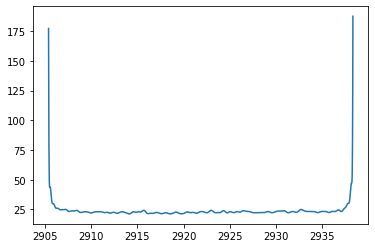

In [26]:
"""
plt.plot(pre.TIME, pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX)) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, np.abs(pre.PDCSAP_FLUX - np.median(pre.PDCSAP_FLUX) - pre.PDCSAP_FLUX_ERR) / np.std(pre.PDCSAP_FLUX))
plt.show()

plt.plot(pre.TIME, (pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1)/np.std(pre.PDCSAP_FLUX))
plt.show()
"""

### what I end up using
# data detrended
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

plt.plot(pre.TIME, pred_pre)
plt.show()

plt.plot(pre.TIME, norm_flux_pre)
plt.show()

# data detrended minus error, with detrending propagated
plt.plot(pre.TIME, (norm_flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(norm_flux_pre-pred_pre))
plt.show()

# GP model detrended
plt.plot(pre.TIME, (flux_pre-pred_pre)/np.std(flux_pre-pred_pre))
plt.show()
print(np.max((flux_pre-pred_pre)/np.std(flux_pre-pred_pre)))

# GP model detrended minus error, with detrending propagated
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))
plt.show()
print(np.max((flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))))

# data error with detrending propagated
plt.plot(pre.TIME, pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))
plt.show()

# GP model variance
plt.plot(pre.TIME, pred_var_pre)
plt.show()


Functionalize everything

In [131]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap

def analyze_recovery(df, t0_fake, istart_gap, istop_gap):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - df: original DataFrame cut into pre/post/postgap/whatever
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - istart_gap: one of the outputs of recover_flares(); all the flare start time indices
    - istop_gap: one of the outputs of recover_flares(); all the flare stop time indices
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    try:
        pred_flares = pd.DataFrame({'istart': np.array(df.TIME)[istart_gap], 
                                    'istop': np.array(df.TIME)[istop_gap],
                                   'gap': np.array(df.TIME)[istop_gap]-np.array(df.TIME)[istart_gap]})
    except:
        print("no true positives")
        return 
    
    tps = 0
    for i in t0_fake:
        # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
        if (np.abs(i - pred_flares['istart']) < np.max(pred_flares['gap'])).any():
            tps += 1
    
    fps = np.abs(len(istart_gap) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.7
N2 = 1.7
N3 = 1
norm_var_pre = pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX) # propagate error through normalization

#candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(flux_pre, pred_var_pre, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_post, istart_gap_post, istop_gap_post = recover_flares(flux_post, pred_var_post, N1=N1, N2=N2, N3=N3, minsep=3)
#candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(flux_postgap, pred_var_postgap, N1=N1, N2=N2, N3=N3, minsep=3)
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)

print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))

"""
candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)
print(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))
print(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))
print(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))
"""

(17, 1, 3)
(7, 1, 3)
(10, 0, 10)


'\ncandidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre.PDCSAP_FLUX, pre.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_post, istart_gap_post, istop_gap_post = recover_flares(post.PDCSAP_FLUX, post.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\ncandidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap.PDCSAP_FLUX, postgap.PDCSAP_FLUX_ERR, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=False)\nprint(analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre))\nprint(analyze_recovery(post, t0_fake_post, istart_gap_post, istop_gap_post))\nprint(analyze_recovery(postgap, t0_fake_postgap, istart_gap_postgap, istop_gap_postgap))\n'

In [132]:
print(pre.PDCSAP_FLUX_ERR)
print(pred_var_pre)
print(pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX_ERR) - 1)
print(pred_var_pre/np.median(pred_var_pre) - 1)
print((pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))**2)
#properly normalize this!!!

1       22.353420
2       22.366695
3       22.378389
4       22.391329
5       22.427473
          ...    
1607    22.942354
1608    22.937656
1609    22.937845
1610    22.940638
1611    22.949953
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[177.24220854 116.02774964  79.47362831 ...  85.15800413 123.54878833
 187.54829747]
1      -0.022793
2      -0.022212
3      -0.021701
4      -0.021135
5      -0.019555
          ...   
1607    0.002953
1608    0.002748
1609    0.002756
1610    0.002878
1611    0.003286
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32
[6.7620043  4.08122698 2.48040487 ... 2.7293419  4.41059737 7.21334096]
1       1.288054e-09
2       1.289584e-09
3       1.290933e-09
4       1.292427e-09
5       1.296602e-09
            ...     
1607    1.356819e-09
1608    1.356264e-09
1609    1.356286e-09
1610    1.356617e-09
1611    1.357718e-09
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32


So our flare identification threshold is {1.7, 1.7, 1}.

### 6) Flare identification: Altaipony

In [133]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
norm_flux_post = post.PDCSAP_FLUX/np.median(post.PDCSAP_FLUX) - 1 
norm_flux_postgap = postgap.PDCSAP_FLUX/np.median(postgap.PDCSAP_FLUX) - 1 
N1 = 1.3
N2 = 1.3
N3 = 2

candidates_pre, istart_gap_pre, istop_gap_pre = recover_flares(pre, norm_flux_pre, pred_pre, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post = recover_flares(post, norm_flux_post, pred_post, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap = recover_flares(postgap, norm_flux_postgap, pred_postgap, N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
print(len(istart_gap_pre))
print(len(istart_gap_post))
print(len(istart_gap_postgap))
print(istart_gap_pre)
print(istart_gap_post)
print(istart_gap_postgap)

17
9
6
[  78  184  378  420  528  630  705  756  968 1064 1154 1166 1246 1335
 1344 1417 1435]
[  7 147 157 225 351 474 568 575 653]
[ 17 229 440 547 722 990]


Check how predictions match up

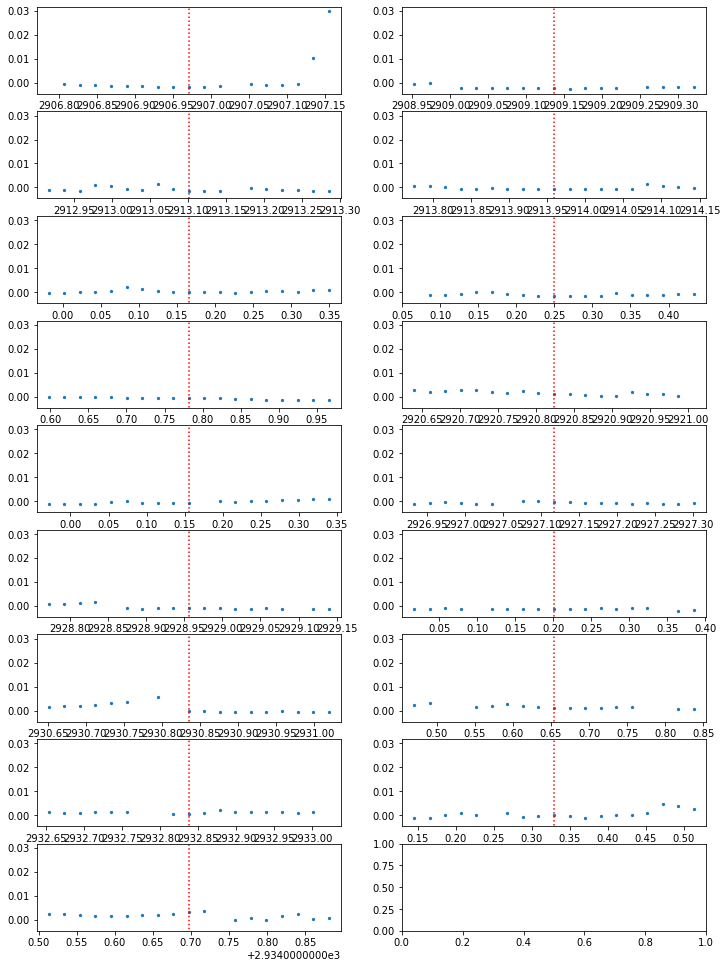

In [153]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(istart_gap_pre)/2).astype(int), figsize=[12,len(istart_gap_pre)])
axes = axes.flatten()
for i in range(len(istart_gap_pre)):
    ax = axes[i]
    ax.scatter(pre.TIME, norm_flux_pre-pred_pre, s=5)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(pre.TIME[istart_gap_pre[i]], -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

Uh...not good. 

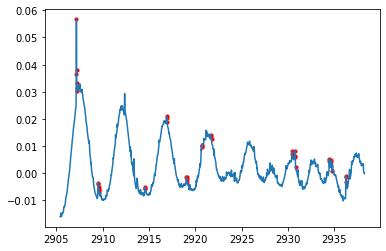

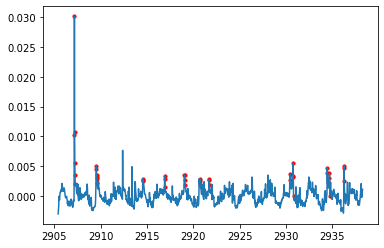

In [31]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

plt.plot(pre.TIME, norm_flux_pre-pred_pre)
plt.scatter(np.array(pre.TIME)[candidates_pre], np.array(norm_flux_pre-pred_pre)[candidates_pre], c='r', s=10)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()



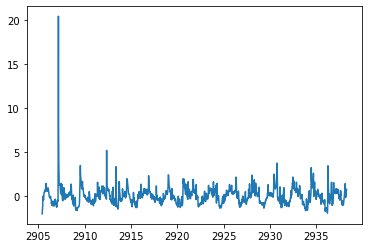

In [32]:
norm_flux_pre = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1 
plt.plot(pre.TIME, (norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre))
plt.show()

Amend recover_flares() to also return pass_thresholds. So it seems that legitimate flares get thrown out during the N3 check.

In [154]:
def recover_flares(df, flux, pred, N1, N2, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    - norm_flag: True or False
        Are you feeding in normalized flux or unnormalized flux?
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    error = df.PDCSAP_FLUX_ERR
    real_flux = df.PDCSAP_FLUX
    
    if norm_flag==True:
        """
        the old way
        #var = pre.PDCSAP_FLUX_ERR
        T0 = flux 
        T1 = np.abs(flux) / np.std(flux) #N1
        T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
        """
        T0 = flux - pred # flux data minus the GP-smoothed quiescent, flare-pared flux
        T1 = T0/np.std(T0)
        T2_numerator = T0-(error/np.median(real_flux)) # whether flux is real_flux or not, since error is real, so is median(flux)
        T2 = T2_numerator/np.std(T2_numerator)
        
    elif norm_flag=='Altaipony': # this was just for testing
        median = np.median(flux)
        sigma = np.std(flux)
        T0 = flux - median # excursion should be positive #"N0"
        T1 = np.abs(flux - median) / sigma #N1
        T2 = np.abs(flux - median - error) / sigma #N2
        #print("T0: ", T0)
        #print("T1: ", T1)
        #print("T2: ", T2)
        # hold on, this doesn't seem to get me what I'd expect (see plots in cell above)
        
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
    #print("pass thresholds: ", pass_thresholds)
    
    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    #print(istart_gap)
    #print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    #print(len(istart_gap))
    
    return candidates, istart_gap, istop_gap, pass_thresholds

N1 = 1.3
N2 = 1.3
N3 = 2
candidates_pre, istart_gap_pre, istop_gap_pre, pass_thresholds_pre = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_post, istart_gap_post, istop_gap_post, pass_thresholds_post = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)
candidates_postgap, istart_gap_postgap, istop_gap_postgap, pass_thresholds_postgap = recover_flares(pre, norm_flux_pre, pred_pre, 
                                                               N1=N1, N2=N2, N3=N3, minsep=3, norm_flag=True)


In [ ]:
def recover_flares_scipy(df, flux, pred, N1, N3, minsep, norm_flag):
    """
    Params:
    - df: DataFrame from which error comes (PDCSAP_FLUX_ERR), as well as real flux (PDCSAP_FLUX) for median division
    - flux: normalized GP-predicted flux with flares injected OR normalized flux data
    - pred: GP-predicted flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.

    Returns:
    - peaks: tpeaks
    - prominences: prominences
    - left_bases: istart_gap
    - right_bases: istop_gap
    """

    norm = flux - pred
    norm_std = norm/np.std(norm)
    
    peaks, _ = find_peaks((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), height=N1, distance=N3)
    prominences, left_bases, right_bases = peak_prominences((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), peaks)
    
    return peaks, prominences, left_bases, right_bases

def analyze_recovery_scipy(df, t0_fake, istart_gap, istop_gap):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - df: original DataFrame cut into pre/post/postgap/whatever
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - istart_gap: one of the outputs of recover_flares(); all the flare start time indices
    - istop_gap: one of the outputs of recover_flares(); all the flare stop time indices
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    try:
        pred_flares = pd.DataFrame({'istart': np.array(df.TIME)[istart_gap], 
                                    'istop': np.array(df.TIME)[istop_gap],
                                   'gap': np.array(df.TIME)[istop_gap]-np.array(df.TIME)[istart_gap]})
    except:
        print("no true positives")
        return 
    
    tps = 0
    for i in t0_fake:
        # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
        if (np.abs(i - pred_flares['istart']) < np.max(pred_flares['gap'])).any():
            tps += 1
    
    fps = np.abs(len(istart_gap) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

### 6.5 Good 'ol scipy.signal.find_peaks

Before I do any injection-recovery analysis, I need to find find_peaks() and peak_prominences() parameters that don't lead to repetitive left_bases or right_bases.

In [195]:
height = 1.3
distance = 10
wlen = 10
width_left = 1
width_right = 8
peaks, _ = find_peaks((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), height=height, distance=distance, 
                      width=(width_left,width_right), wlen=wlen)
#print(peaks, len(peaks))
prominences, left_bases, right_bases = peak_prominences((norm_flux_pre-pred_pre)/np.std(norm_flux_pre-pred_pre), peaks)
print(prominences, len(prominences), len(left_bases), len(right_bases))
#print(left_bases)
#print(right_bases)

flares_scipy = pd.DataFrame({'peaks': peaks, 'left_bases': left_bases, 'right_bases': right_bases})
print(flares_scipy)

[ 2.68045247 22.32562149  1.12818053  1.88961768  4.56634605  0.86078721
  1.94070092  4.49113667  2.2304281   3.2772193   1.55840087  3.40310764
  3.77234685  1.12827656  1.93533987  2.28110993  1.70241931  2.84926844
  2.23138994  1.08694056  3.3994838   1.6009994   3.75001144  1.45654547
  1.42019384  1.68328005  5.2192564   3.46781921  1.18820602  4.87065947
  1.67637718  4.48897779  2.43762922  2.55427194  1.57429652] 35 35 35
    peaks  left_bases  right_bases
0      19           0           70
1      79           0         1415
2      91          89          169
3     140          99          169
4     185         169          250
5     195         193          250
6     270         250          282
7     364         363          374
8     378         374          389
9     420         374          468
10    488         468          495
11    528         374          593
12    630         374          887
13    719         718          728
14    730         728          742
15  

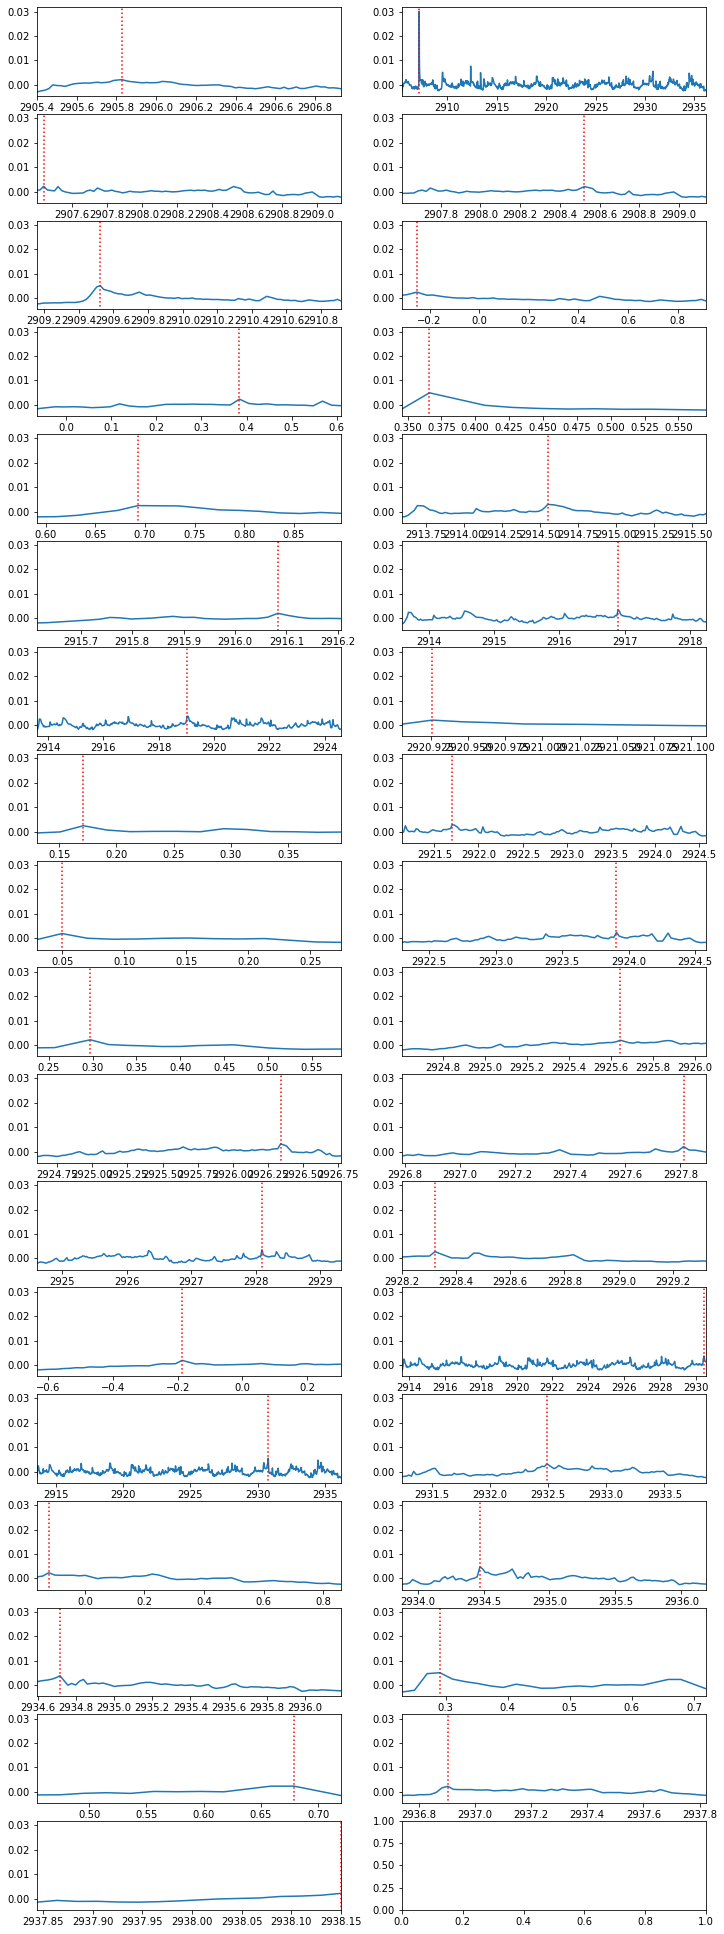

In [192]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(peaks)/2).astype(int), figsize=[12,len(peaks)])
axes = axes.flatten()

for i in range(len(peaks)):    
    snapshot = (norm_flux_pre-pred_pre).iloc[left_bases[i]:right_bases[i]]
    """
    tpeak = pre.TIME[snapshot.idxmax()]
    ampl = snapshot.max()
    #half_max_left = snapshot.loc[(snapshot >= 0.5*ampl) & ()
    #fwhm = np.asarray(npts) * (2/1440)
    peaks, _ = find_peaks(snapshot.array)
    fwhm = get_fwhm(snapshot)
    fwhms.append(fwhm)
    tpeaks.append(tpeak)
    ampls.append(ampl)
    """
    ax = axes[i]
    ax.plot(pre.TIME, norm_flux_pre-pred_pre)
    ax.axvline(pre.TIME.iloc[peaks[i]], -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[snapshot.index].min(), pre.TIME[snapshot.index].max())
    #ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))
plt.show()

#### Calculate ampls and fwhms

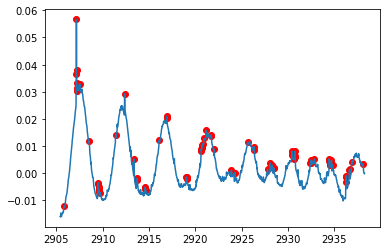

In [116]:
plt.plot(pre.TIME, norm_flux_pre)
plt.scatter(np.array(pre.TIME)[pass_thresholds_pre], np.array(norm_flux_pre)[pass_thresholds_pre], c='r')

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_14142/713837762.py:8: PeakPropertyWarning: some peaks have a prominence of 0
  fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_14142/713837762.py:8: PeakPropertyWarning: some peaks have a width of 0
  fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_14142/713837762.py:8: PeakPropertyWarning: some peaks have a prominence of 0
  fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_14142/713837762.py:8: PeakPropertyWarning: some peaks have a width of 0
  fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds
/var/folde

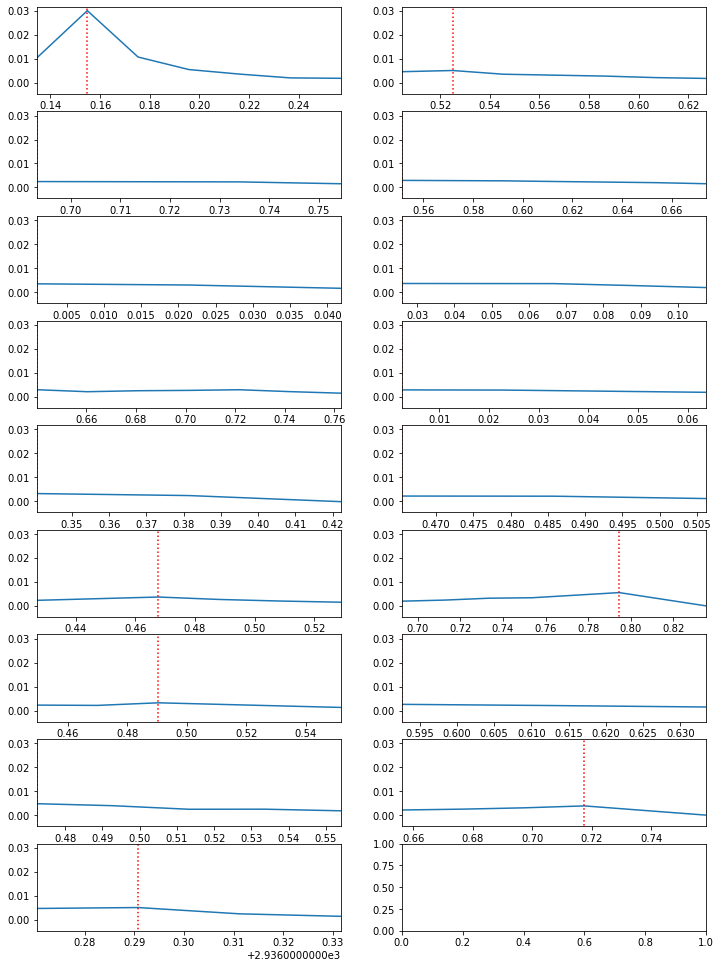

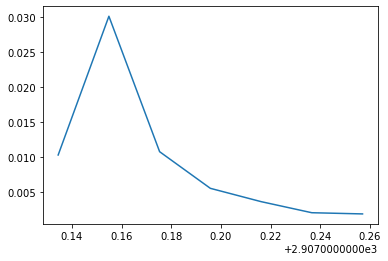

In [117]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_fwhm(snapshot): # eh, let's use scipy.signal.peak_prominences instead 
    """
    snapshot: a single pd.Series chunk that's the output of consecutive(data), where data is the output of recover_flares()
    """
    fwhm = peak_widths(snapshot.array, [snapshot.argmax()], rel_height=0.5)[0][0]*30*60 # 30 min cadence in seconds 
    # ie. if the snapshot is too narrow for peak_widths to work
    if fwhm == 0: 
        # assert that the equivalent duration is just half of istop-istart
        fwhm = (snapshot.index.max()-snapshot.index.min())*30*60*0.5
        
    return fwhm

"""
print(candidates_pre)
print(consecutive(candidates_pre))
print(consecutive(candidates_pre)[0])
print(pre.TIME.iloc[consecutive(candidates_pre)[0]])
print((norm_flux_pre-pred_pre))
"""

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(istart_gap_pre)/2).astype(int), figsize=[12,len(istart_gap_pre)])
axes = axes.flatten()
tpeaks = []
ampls = []
fwhms = []
for i in range(len(istart_gap_pre)):    
    snapshot = (norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[i]]
    tpeak = pre.TIME[snapshot.idxmax()]
    ampl = snapshot.max()
    #half_max_left = snapshot.loc[(snapshot >= 0.5*ampl) & ()
    #fwhm = np.asarray(npts) * (2/1440)
    peaks, _ = find_peaks(snapshot.array)
    fwhm = get_fwhm(snapshot)
    fwhms.append(fwhm)
    tpeaks.append(tpeak)
    ampls.append(ampl)
    
    ax = axes[i]
    ax.plot(pre.TIME, norm_flux_pre-pred_pre)
    ax.axvline(tpeak, -1, 1, color='r', linestyle=':')
    ax.set_xlim(pre.TIME[snapshot.index].min(), pre.TIME[snapshot.index].max())
    #ax.set_xlim(pre.TIME[istart_gap_pre[i]]-0.2, pre.TIME[istart_gap_pre[i]]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))
plt.show()

#print((norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]])
#print(np.argmax((norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]]))

flares = pd.DataFrame({'istart': istart_gap_pre, 'istop': istop_gap_pre, 'tpeak': tpeaks, 'ampls': ampls, 'fwhms': fwhms})
plt.plot(pre.TIME.iloc[consecutive(candidates_pre)[0]], (norm_flux_pre-pred_pre).iloc[consecutive(candidates_pre)[0]])
#plt.axvline(pre.TIME[consecutive
plt.show()

In [118]:
flares

,istart,istop,tpeak,ampls,fwhms
0,78,84,2907.154837,0.030113,1821.957585
1,184,190,2909.524974,0.005143,1191.823462
2,378,381,2913.693127,0.002454,2700.000000
3,420,424,2914.551273,0.002944,5400.000000
4,528,530,2916.900956,0.003435,1800.000000
5,630,633,2919.025881,0.003574,3600.000000
6,705,711,2920.640003,0.002917,5400.000000
7,756,758,2921.702462,0.002827,2700.000000
8,968,970,2926.340490,0.003218,3600.000000
9,1064,1066,2928.465395,0.002188,1800.000000


#### What if I combined find_peaks() with xoflares find_flares()? Either way, I need to add find_peaks() to recover_flares() to analyze its injection-recovery effectiveness. We can see if that enables better models from pymc3. Otherwise, I may have to craft a bootstrap from scratch to do manually flare by flare.

Instead of GPs, how about savgol?

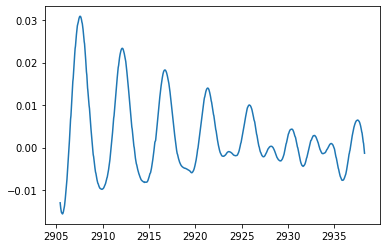

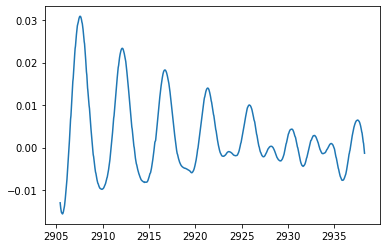

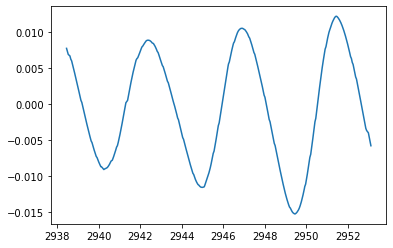

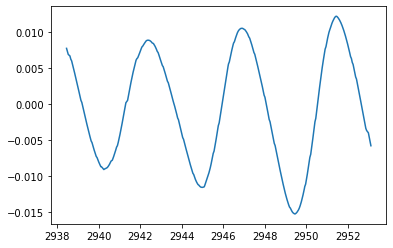

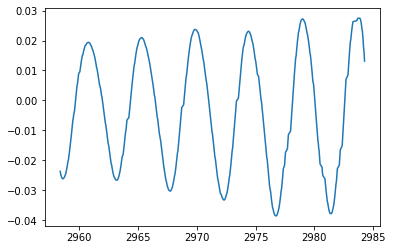

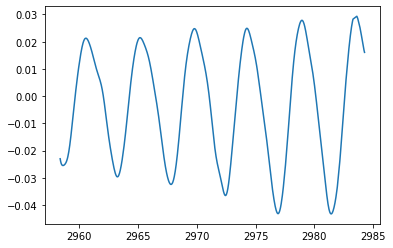

In [198]:
from scipy.signal import savgol_filter

def normalize_flux(flux):
    return flux/np.median(flux) - 1

norm_pre = normalize_flux(pre.PDCSAP_FLUX)
norm_post = normalize_flux(post.PDCSAP_FLUX)
norm_postgap = normalize_flux(postgap.PDCSAP_FLUX)

savgol_pre = savgol_filter(norm_pre, 109, polyorder=3)
savgol_post = savgol_filter(norm_post, 149, polyorder=3)
savgol_postgap = savgol_filter(norm_postgap, 129, polyorder=3)

plt.plot(pre.TIME, savgol_pre)
plt.show()

plt.plot(pre.TIME, pred_pre) # oops, was previously the GP model
plt.show()


plt.plot(post.TIME, savgol_post)
plt.show()

plt.plot(post.TIME, pred_post) # oops, was previously the GP model
plt.show()


plt.plot(postgap.TIME, savgol_postgap)
plt.show()

plt.plot(postgap.TIME, pred_postgap)
plt.show()

Looks like savgol has GPs beat for pre and post, but GP is a better detrending for postgap. So we'll use savgol_pre, savgol_post, and pred_postgap.

### 7) Flare recovery and identification: xoflares

I'm going to switch to xoflares because that already has fwhm calculations built in. The only thing I need to do is adapt it to allow for injection recovery.

In [347]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

def find_flares(lc, flux, pred, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - pred: GP-predicted spot modulation flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux-pred # save this for ampls
    flux = (flux-pred)/np.std(flux-pred) # subtract out GP-modeled spot modulation flux
    mflare = (flux < N1) & (flux - lc.PDCSAP_FLUX_ERR/np.median(lc.PDCSAP_FLUX) < N2)

    """
    # this part is from Altaipony/Appaloosa
    is_pass_thresholds = np.array(mflare)
    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    N3 = 2
    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]
    print(candidates)
    print(istart_gap)
    print(istop_gap)
    print(len(istart_gap), len(candidates))
    """
    
    # resume flare identification code from xoflares
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([lc.TIME.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    print(len(tpeaks))
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.3
N2 = 1.3
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
_, _, tpeaks_pre, _, _, _, _, _ = find_flares(pre, flux_pre, savgol_pre, N1, N2)
_, _, tpeaks_post, _, _, _, _, _ = find_flares(post, flux_post, savgol_post, N1, N2)
_, _, tpeaks_postgap, _, _, _, _, _ = find_flares(postgap, flux_postgap, pred_postgap, N1, N2)

idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre, fps_pre, fns_pre = analyze_recovery_for_xoflares(tpeaks_pre, t0_fake_pre, tol=tol*idx_interval)
tps_post, fps_post, fns_post = analyze_recovery_for_xoflares(tpeaks_post, t0_fake_post, tol=tol*idx_interval)
tps_postgap, fps_postgap, fns_postgap = analyze_recovery_for_xoflares(tpeaks_postgap, 
                                                                      t0_fake_postgap, tol=tol*idx_interval)

print(tps_pre, fps_pre, fns_pre)
print(tps_post, fps_post, fns_post)
print(tps_postgap, fps_postgap, fns_postgap)


18
7
10
18 0 2
8 1 2
10 0 10


Note that my assessment of TPs is not perfect. For example, I've only predicted 16 flares in pre; yet, I have 18 TPs (another sign is that 16+2+2 is not 20). But most likely, pre is 16 TP, 0 FP, and 4 FN.

Okay, so savgol vs GP makes no difference with my light curve (toggle between first two and second two find_flares() runs in cell above).

Let's identify some real flares and hope they're finally right.

In [200]:
x_pre, y_pre, tpeaks_pre, tpeaks_norm_pre, ampls_pre, unnorm_ampls_pre, fwhms_pre, npeaks_pre = find_flares(pre, norm_flux_pre, 
                                                                                          savgol_pre, N1, N2)
x_post, y_post, tpeaks_post, tpeaks_norm_post, ampls_post, unnorm_ampls_post, fwhms_post, npeaks_post = find_flares(post, norm_flux_post, 
                                                                                          savgol_post, N1, N2)
x_postgap, y_postgap, tpeaks_postgap, tpeaks_norm_postgap, ampls_postgap, unnorm_ampls_postgap, fwhms_postgap, npeaks_postgap = find_flares(postgap,
                                                                        norm_flux_postgap, pred_postgap, N1, N2)
print(npeaks_pre, npeaks_post, npeaks_postgap)

48 16 23


In [205]:
print(len(x_pre), len(y_pre), len(tpeaks_pre), len(tpeaks_norm_pre), len(ampls_pre), len(fwhms_pre))
out_pre = pd.DataFrame({'tpeak': tpeaks_pre, 'tpeaks_norm': tpeaks_norm_pre, 'ampls': ampls_pre, 'unnorm_ampls': unnorm_ampls_pre, 'fwhms': fwhms_pre})
out_post = pd.DataFrame({'tpeak': tpeaks_post, 'tpeaks_norm': tpeaks_norm_post, 'ampls': ampls_post, 'unnorm_ampls': unnorm_ampls_post, 'fwhms': fwhms_post})
out_postgap = pd.DataFrame({'tpeak': tpeaks_postgap, 'tpeaks_norm': tpeaks_norm_postgap, 'ampls': ampls_postgap, 'unnorm_ampls': unnorm_ampls_postgap,
                            'fwhms': fwhms_postgap})
out = pd.concat([out_pre, out_post, out_postgap]).reset_index()
print(out)
print(out.loc[out.ampls>0])
#out.to_csv('identified_flares.csv', index=False)

1511 1511 48 48 48 48
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722
2       2  2907.297863   -14.547486  1.309872      0.001932  0.002778
3       3  2907.440889   -14.404460  1.451282      0.002140  0.002778
4       4  2907.522618   -14.322731  1.368187      0.002018  0.002778
..    ...          ...          ...       ...           ...       ...
82     18  2977.991542     6.670886  1.682145      0.002124  0.002778
83     19  2978.216291     6.895634  1.356167      0.001713  0.002778
84     20  2979.176580     7.855923  1.439159      0.001818  0.002778
85     21  2979.626077     8.305420  1.309828      0.001654  0.002778
86     22  2981.669248    10.348591  4.987364      0.006299  0.004167

[87 rows x 6 columns]
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0       0  2905.826740   -16.018609  1.458995

In [206]:
pred_pre_df = pd.DataFrame(savgol_pre, columns=['flux_norm'])
pred_post_df = pd.DataFrame(savgol_post, columns=['flux_norm'])
pred_postgap_df = pd.DataFrame(pred_postgap, columns=['flux_norm'])
pred_df = pd.concat([pred_pre_df, pred_post_df, pred_postgap_df])
print(pred_df)
#pred_df.to_csv('preds.csv',index=False)

      flux_norm
0     -0.012985
1     -0.013459
2     -0.013883
3     -0.014258
4     -0.014585
...         ...
1066   0.018153
1067   0.017673
1068   0.016795
1069   0.016409
1070   0.016069

[3253 rows x 1 columns]


### 7.5 xoflares + scipy.signal.find_peaks()

Take flares identified by xoflares and get tpeaks, istart, and istop using find_peaks(), as well as prune identified flares that don't actually have a peak.

#### Recovery analysis on fake flares

In [341]:
# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

def find_flares(lc, flux, pred, N1, N2):
    """
    Adapted from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares
    Params:
    - lc: DataFrame with PDCSAP_FLUX_ERR, PDCSAP_FLUX, and CADENCENO fields
    - flux:  GP-predicted flux with flares injected
    - pred: GP-predicted spot modulation flux
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
        
    Returns:
    - x: lc.TIME - ref_time
    - y: flux param
    - tpeaks: start time of flares (corresponds to lc.TIME)
    - tpeaks_norm: start time of flares (normalized to correspond to x)
    - ampls: flare amplitudes
    - fwhms: full-width half-maxes of flares
    - npeaks: number of flares identified
    """
    
    # find some flares
    #mflare = flux < N1 * np.sqrt(np.mean(flux**2))
    unnorm_flux = flux-pred # save this for ampls
    flux = (flux-pred)/np.std(flux-pred) # subtract out GP-modeled spot modulation flux
    mflare = (flux < N1) & (flux - lc.PDCSAP_FLUX_ERR/np.median(lc.PDCSAP_FLUX) < N2)

    """
    # this part is from Altaipony/Appaloosa
    is_pass_thresholds = np.array(mflare)
    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    N3 = 2
    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    #print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]
    print(candidates)
    print(istart_gap)
    print(istop_gap)
    print(len(istart_gap), len(candidates))
    """
    
    # resume flare identification code from xoflares
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index CADENCENO at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = flux # data with savgol subtracted OR normalized data

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                # if I care about consecutive points, this is where I'd deal with it
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
            
    tpeaks = np.array([lc.TIME.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    tpeaks_norm = np.array([x.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    try: # if flux given is a DataFrame (eg. norm_flux_pre)
        unnorm_ampls = np.array([unnorm_flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
        ampls = np.array([flux.loc[cads == fidx[i]].values for i in range(len(fidx))]).T[0]
    except: # if flux given is a np.array (eg. flux_pre)
        unnorm_ampls = np.array([unnorm_flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
        ampls = np.array([flux[cads == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440) 
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    #print(fidx)
    
    ### enter: scipy.signal.find_peaks() for cleanup duty
    height = 1.4
    distance = 10
    wlen = 5
    width_left = None
    width_right = 10
    buffer = 0.1 # essentially the wlen for find_peaks()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = lc.TIME[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        snapshot = unnorm_flux[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        snapshot_std = flux[(lc.TIME > tpeaks[i]-buffer) & (lc.TIME < tpeaks[i]+buffer)] 
        
        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #tpeaks = np.array(snapshot_time)[peaks]
        print(peaks)
    
    return x, y, tpeaks, tpeaks_norm, ampls, unnorm_ampls, fwhms, npeaks

def analyze_recovery_for_xoflares(tpeaks, t0_fake, tol):
    # analyze_recovery(pre, t0_fake_pre, istart_gap_pre, istop_gap_pre)
    """
    Calculate TPs, FPs, and FNs
    Params: 
    - tpeaks: recovered tpeaks (so not really start times, but we'll use a tolerance to get around that
    - t0_fake: one of the outputs of inject_fakes(); all of the ground truth flare start times
    - tol: tolerance [days]
    Returns:
    - TPs: true positives (int)
    - FPs: false positives (int)
    - FNs: false negatives (int)
    """
    tps = 0
    #print(len(tpeaks))
    for i in t0_fake:
        if (np.abs(i - tpeaks) < tol).any():
            tps += 1
    
    fps = np.abs(len(tpeaks) - tps)    
    fns = len(t0_fake) - tps
    
    return tps, fps, fns

N1 = 1.1
N2 = 1.1
#x, y, tpeaks, tpeaks_norm, ampls, fwhms, npeaks = find_flares(pre, norm_flux_pre, pred_pre, N1, N2)
#_, _, tpeaks_pre, _, _, _, _ = find_flares(pre, flux_pre, pred_pre, N1, N2) 
#_, _, tpeaks_post, _, _, _, _ = find_flares(post, flux_post, pred_post, N1, N2)
_, _, tpeaks_pre, _, _, _, _, _ = find_flares(pre, flux_pre, savgol_pre, N1, N2)
_, _, tpeaks_post, _, _, _, _, _ = find_flares(post, flux_post, savgol_post, N1, N2)
_, _, tpeaks_postgap, _, _, _, _, _ = find_flares(postgap, flux_postgap, pred_postgap, N1, N2)

idx_interval = pre.TIME[2] - pre.TIME[1] # time spanned by one index
tol = 3 # reminiscent of minsep from altaipony        
tps_pre, fps_pre, fns_pre = analyze_recovery_for_xoflares(tpeaks_pre, t0_fake_pre, tol=tol*idx_interval)
tps_post, fps_post, fns_post = analyze_recovery_for_xoflares(tpeaks_post, t0_fake_post, tol=tol*idx_interval)
tps_postgap, fps_postgap, fns_postgap = analyze_recovery_for_xoflares(tpeaks_postgap, t0_fake_postgap, tol=tol*idx_interval)

print(tps_pre, fps_pre, fns_pre)
print(tps_post, fps_post, fns_post)
print(tps_postgap, fps_postgap, fns_postgap)


[4]
[4]
[4]
[5]
[4]
[2]
[4]
[4]
[4]
[4]
[3]
[3]
[4]
[4]
[4]
[]
[4]
[4]
[4]
[3]
[3]
[5]
[3]
[4]
[4]
[3]
[2]
[4]
[3]
[4]
[4]
[4]
[5]
[3]
[4]
19 1 1
8 1 2
10 0 10


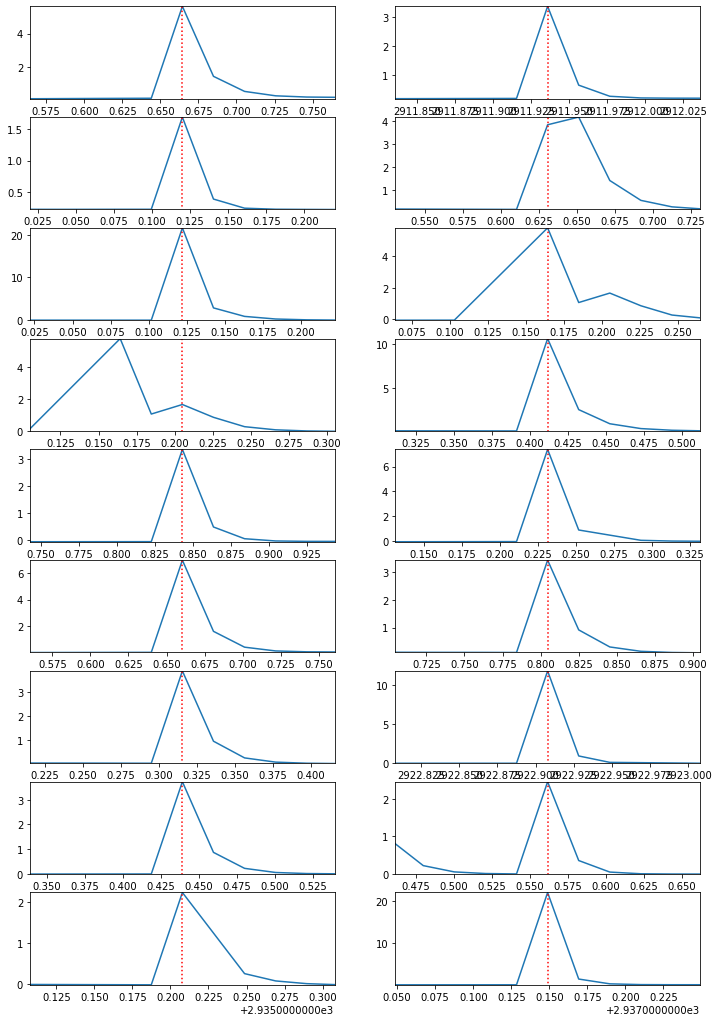

In [318]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(len(tpeaks_pre)/2).astype(int), figsize=[12,len(tpeaks_pre)])
axes = axes.flatten()
flux_pre_std = flux_pre/np.std(flux_pre)
for i in range(len(tpeaks_pre)):
    ### take snapshot of time and flux around identified flare
    snapshot_time = pre.TIME[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)] 
    snapshot = flux_pre[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)] 
    snapshot_std = flux_pre_std[(pre.TIME > tpeaks_pre[i]-buffer) & (pre.TIME < tpeaks_pre[i]+buffer)]
    
    ax = axes[i]
    ax.plot(pre.TIME, flux_pre_std)
    ax.axvline(tpeaks_pre[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_pre[i]-buffer, tpeaks_pre[i]+buffer)
    ax.set_ylim(np.min(snapshot_std), np.max(snapshot_std))
    
plt.show()

Great! Using find_peaks() doesn't remove flares. Just fixes their tpeaks. 

Actually, if I lower the N1 and N2 thresholds for xoflares' find_flares(), I can recover more TPs and then use find_peaks() to prune FPs.

So it's settled: we're going with a more generous N1, N2 = 1.1, N3 = 2, and then impose a harsher threshold of height = 1.4 (plus associated width, etc parameters for find_peaks()).

#### Actual flare identification using xoflares + find_peaks()

In [348]:
N1 = 1.1
N2 = 1.1
N3 = 2
x_pre, y_pre, tpeaks_pre, tpeaks_norm_pre, ampls_pre, unnorm_ampls_pre, fwhms_pre, npeaks_pre = find_flares(pre, norm_flux_pre, 
                                                                                          savgol_pre, N1, N2)
x_post, y_post, tpeaks_post, tpeaks_norm_post, ampls_post, unnorm_ampls_post, fwhms_post, npeaks_post = find_flares(post, norm_flux_post, 
                                                                                          savgol_post, N1, N2)
x_postgap, y_postgap, tpeaks_postgap, tpeaks_norm_postgap, ampls_postgap, unnorm_ampls_postgap, fwhms_postgap, npeaks_postgap = find_flares(postgap,
                                                                        norm_flux_postgap, pred_postgap, N1, N2)
print(npeaks_pre, npeaks_post, npeaks_postgap)


59 25 30


In [360]:
print(len(x_pre), len(y_pre), len(tpeaks_pre), len(tpeaks_norm_pre), len(ampls_pre), len(fwhms_pre))
out_pre = pd.DataFrame({'tpeak': tpeaks_pre, 'tpeaks_norm': tpeaks_norm_pre, 'ampls': ampls_pre, 'unnorm_ampls': unnorm_ampls_pre, 'fwhms': fwhms_pre})
out_post = pd.DataFrame({'tpeak': tpeaks_post, 'tpeaks_norm': tpeaks_norm_post, 'ampls': ampls_post, 'unnorm_ampls': unnorm_ampls_post, 'fwhms': fwhms_post})
out_postgap = pd.DataFrame({'tpeak': tpeaks_postgap, 'tpeaks_norm': tpeaks_norm_postgap, 'ampls': ampls_postgap, 'unnorm_ampls': unnorm_ampls_postgap,
                            'fwhms': fwhms_postgap})
out = pd.concat([out_pre, out_post, out_postgap]).reset_index()
print(out)
print(out.loc[out.ampls>0])
#out.to_csv('identified_flares.csv', index=False)



1511 1511 59 59 59 59
     index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0        0  2905.785876   -16.059473  1.227784      0.001811  0.002778
1        1  2905.826740   -16.018609  1.458995      0.002152  0.004167
2        2  2907.134405   -14.710944  6.983271      0.010299  0.011111
3        3  2907.297863   -14.547486  1.309872      0.001932  0.002778
4        4  2907.338727   -14.506621  1.295454      0.001911  0.002778
..     ...          ...          ...       ...           ...       ...
109     25  2979.176580     7.855923  1.439159      0.001818  0.002778
110     26  2979.626077     8.305420  1.309828      0.001654  0.002778
111     27  2980.729389     9.408732  1.108128      0.001400  0.002778
112     28  2981.669248    10.348591  4.987364      0.006299  0.004167
113     29  2983.978035    12.657379  1.274243      0.001609  0.002778

[114 rows x 6 columns]
     index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms
0        0  2905.785876   -16.0

#### Use find_peaks() to prune xoflares flare identification outputs across all three data chunks.

pre

In [355]:
out

,index,tpeak,tpeaks_norm,ampls,unnorm_ampls,fwhms
0,0,2905.785876,-16.059473,1.227784,0.001811,0.002778
1,1,2905.826740,-16.018609,1.458995,0.002152,0.004167
2,2,2907.134405,-14.710944,6.983271,0.010299,0.011111
3,3,2907.297863,-14.547486,1.309872,0.001932,0.002778
4,4,2907.338727,-14.506621,1.295454,0.001911,0.002778
...,...,...,...,...,...,...
109,25,2979.176580,7.855923,1.439159,0.001818,0.002778
110,26,2979.626077,8.305420,1.309828,0.001654,0.002778
111,27,2980.729389,9.408732,1.108128,0.001400,0.002778
112,28,2981.669248,10.348591,4.987364,0.006299,0.004167


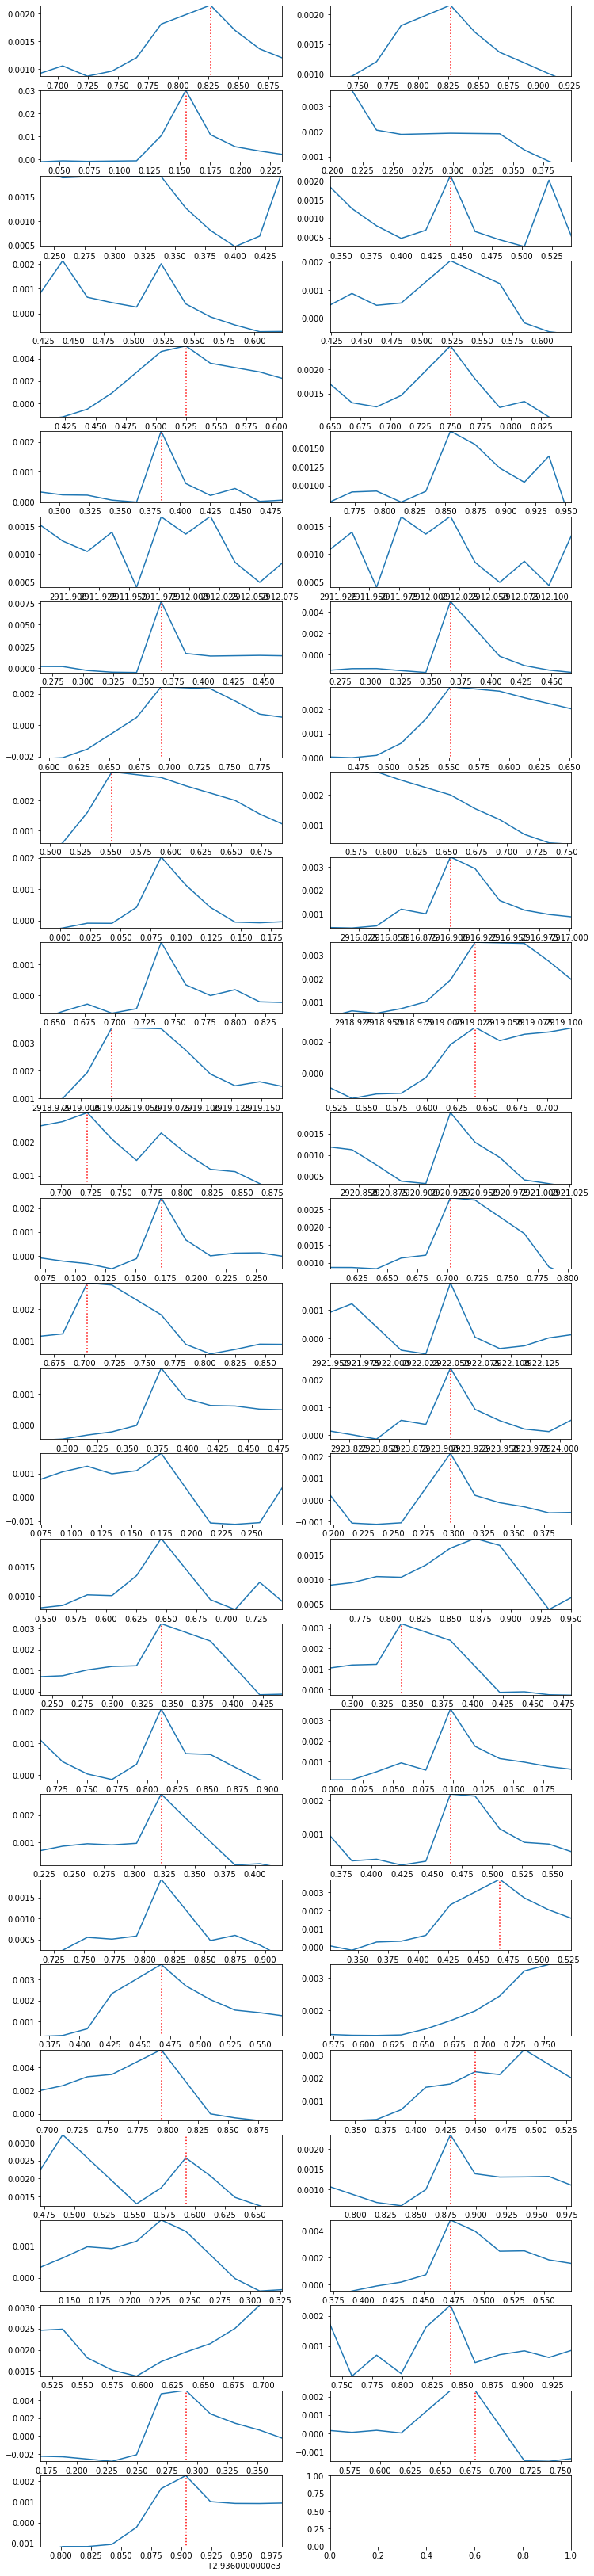

before:  59
after:  39


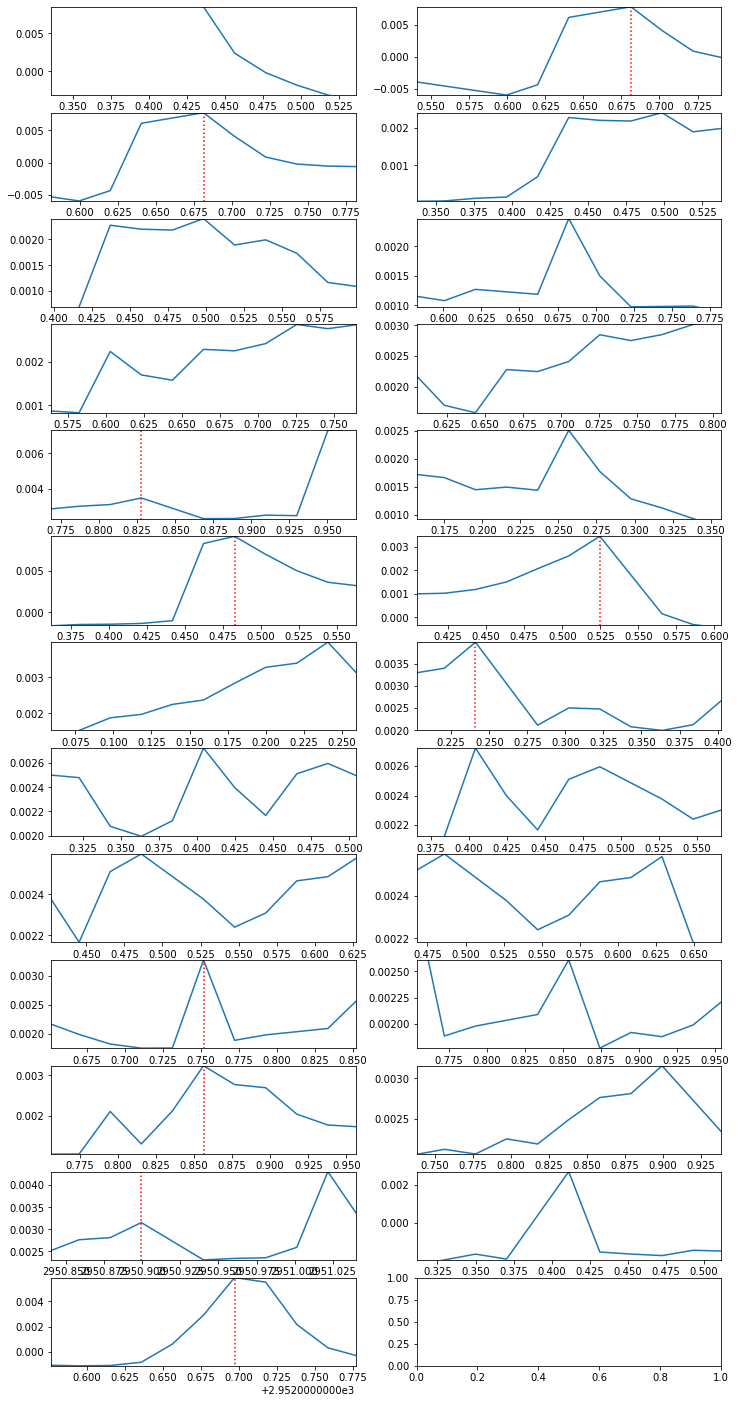

before:  25
after:  10


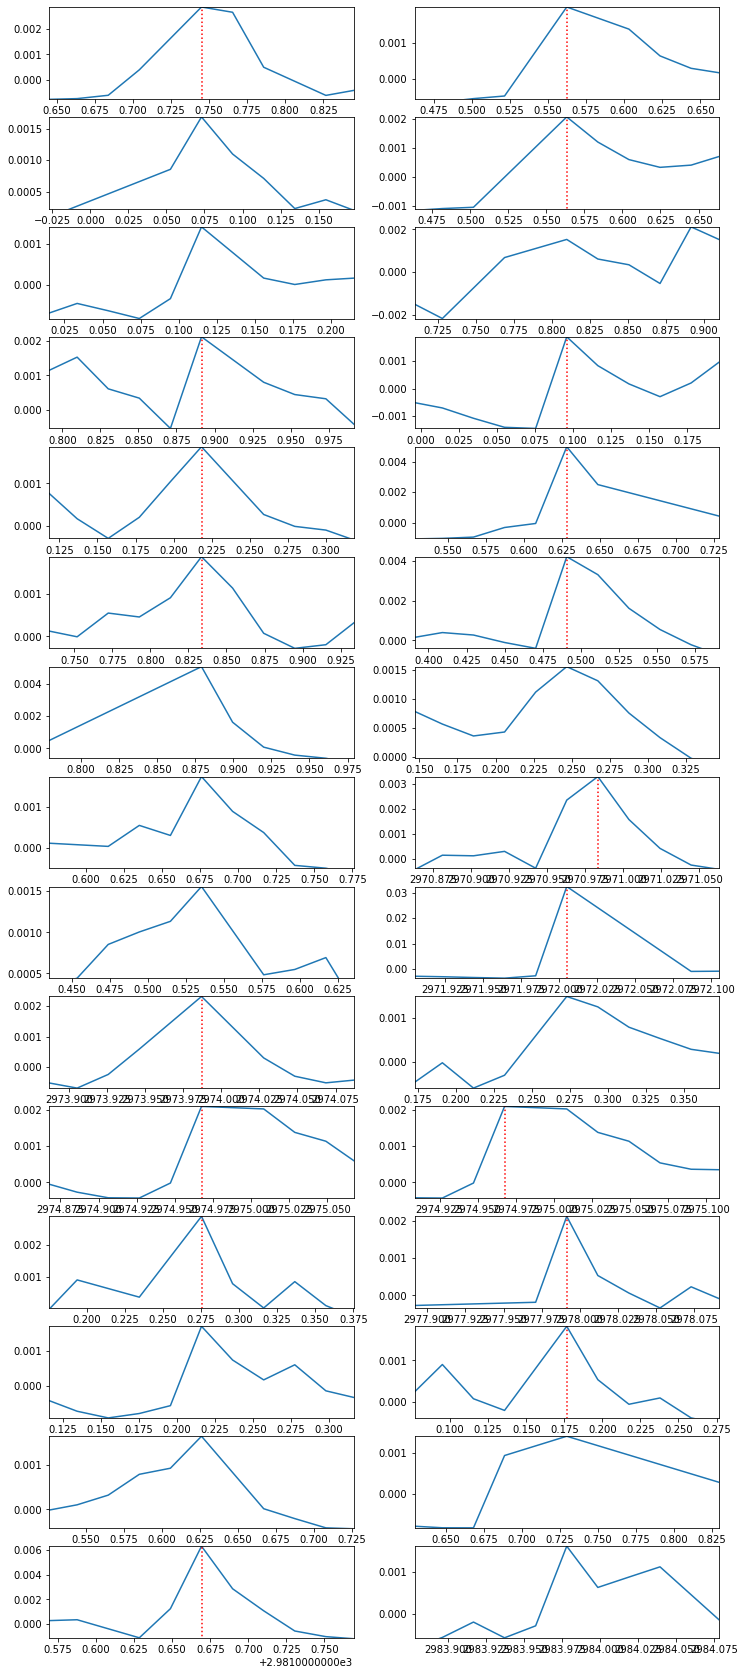

before:  30
after:  18
    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms  \
0       0  2905.785876   -16.059473  1.227784      0.001811  0.002778   
1       1  2905.826740   -16.018609  1.458995      0.002152  0.004167   
2       2  2907.134405   -14.710944  6.983271      0.010299  0.011111   
3       5  2907.440889   -14.404460  1.451282      0.002140  0.002778   
4       8  2909.504541   -12.340807  3.145568      0.004639  0.012500   
..    ...          ...          ...       ...           ...       ...   
62     21  2975.008522     3.687865  1.603894      0.002026  0.002778   
63     22  2976.275283     4.954627  2.286708      0.002888  0.002778   
64     23  2977.991542     6.670886  1.682145      0.002124  0.002778   
65     25  2979.176580     7.855923  1.439159      0.001818  0.002778   
66     28  2981.669248    10.348591  4.987364      0.006299  0.004167   

    fixed_tpeaks fixed_fwhms  
0    2905.826740     [10800]  
1    2905.826740     [12600]  
2    29

In [363]:
def pruning(df, norm_flux, pred, out):
    """
    ### Parameters
    df: original data chunk dataframe, eg. pre
    norm_flux: flux/median - 1, eg. norm_flux_pre
    pred: GP or savgol-smoothed flux, eg. pred_pre
    out: output of xoflares flare identification code find_flares(), eg. out_pre
    
    ### Returns
    
    """
    
    tpeaks = out.tpeak
    npeaks = len(tpeaks)
    tpeaks_norm = out.tpeaks_norm
    ampls = out.ampls
    unnorm_ampls = out.unnorm_ampls
    fwhms = out.fwhms
    
    detrended_std = (norm_flux - pred)/np.std(norm_flux - pred)
    detrended = norm_flux - pred

    height = 1.4
    distance = 5
    wlen = 5
    width_left = None
    width_right = 5
    buffer = 0.1 # essentially the wlen for find_peaks()

    fixed_tpeaks = []
    fixed_fwhms = []

    fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
    axes = axes.flatten()
    for i in range(npeaks):
        ### take snapshot of time and flux around identified flare
        snapshot_time = df.TIME[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 
        snapshot = detrended[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 
        snapshot_std = detrended_std[(df.TIME > tpeaks[i]-buffer) & (df.TIME < tpeaks[i]+buffer)] 

        ### run scipy.signal.find_peaks() to identify actual peak
        peaks, _ = find_peaks(snapshot_std, height=height, distance=distance, width=(width_left,width_right))
        prominences, left_bases, right_bases = peak_prominences(snapshot_std, peaks)
        #print(np.array(snapshot_time)[peaks], tpeaks_pre[i])

        ### plot
        ax = axes[i]
        ax.plot(df.TIME, detrended) # norm_flux_pre
        if len(peaks)>0:
            ax.axvline(np.array(snapshot_time)[peaks][0], -1, 1, color='r', linestyle=':')
            fixed_tpeaks.append(np.array(snapshot_time)[peaks][0])
            fixed_fwhm = (right_bases-left_bases)*30*60
            fixed_fwhms.append(fixed_fwhm)
        else:
            fixed_tpeaks.append(np.nan) # for dropping later
            fixed_fwhms.append(np.nan)

        ax.set_xlim(tpeaks[i]-buffer, tpeaks[i]+buffer)
        ax.set_ylim(min(snapshot), max(snapshot))

    plt.show()

    # attach fixed tpeaks and fwhm columns to xoflares flare identification dataframe, then drop nans
    out['fixed_tpeaks'] = fixed_tpeaks
    out['fixed_fwhms'] = fixed_fwhms
    print("before: ", len(out))
    out = out.dropna()
    print("after: ", len(out))
    
    return out

out_pre_fixed = pruning(pre, norm_flux_pre, pred_pre, out_pre)
out_post_fixed = pruning(post, norm_flux_post, pred_post, out_post)
out_postgap_fixed = pruning(postgap, norm_flux_postgap, pred_postgap, out_postgap)
out_fixed = pd.concat([out_pre_fixed, out_post_fixed, out_postgap_fixed]).reset_index()
print(out_fixed)
out_fixed.to_csv('identified_flares.csv', index=False)

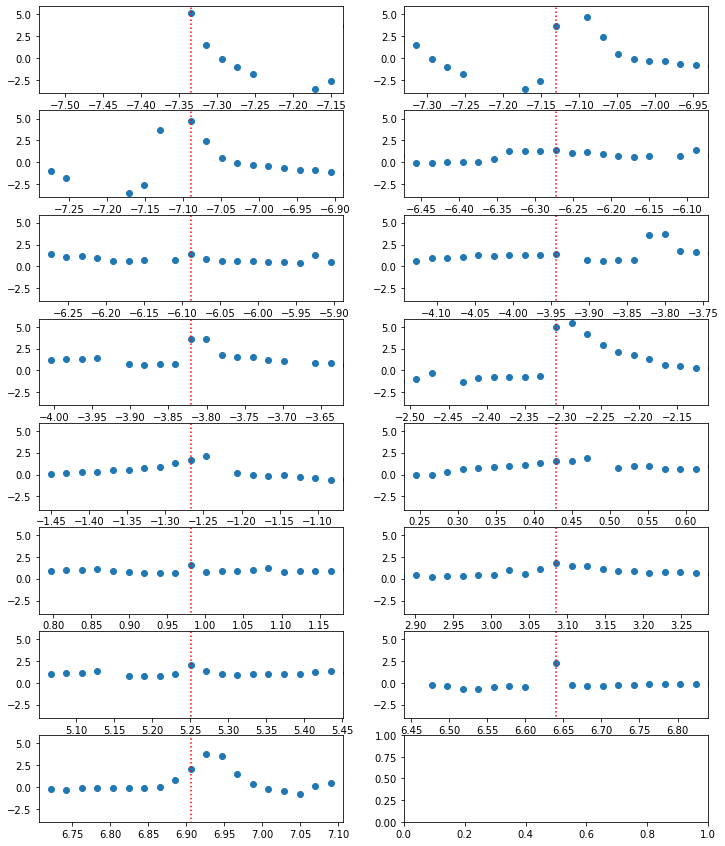

In [144]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_post/2).astype(int), figsize=[12,npeaks_post])
axes = axes.flatten()
for i in range(npeaks_post):
    ax = axes[i]
    ax.scatter(x_post, y_post)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_post[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_post[i]-0.2, tpeaks_norm_post[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

We can throw away the first identified flare because that's just the downslope of the super-flare. We can also combine the second and third identified flares because they're the same event. Why did they get double-counted, though?

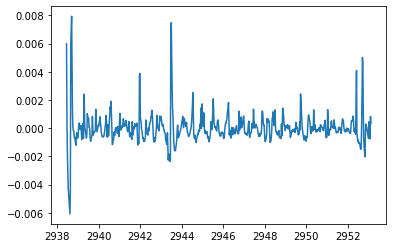

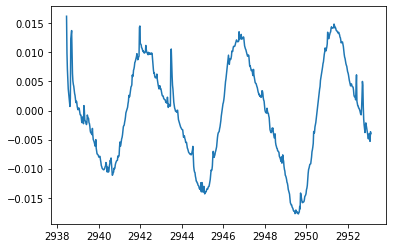

In [132]:
plt.plot(post.TIME, norm_flux_post - pred_post)
plt.show()

plt.plot(post.TIME, norm_flux_post)
plt.show()

In [149]:
print(tpeaks_post)
print(post.loc[(post.TIME < 2938.75) & (post.TIME > 2938.5)].TIME)

[2938.43605659 2938.64037271 2938.68123593 2939.49850037 2939.68238477
 2941.82770175 2941.95029121 2943.46222768 2944.5042374  2946.20005625
 2946.75170786 2948.85615609 2951.02189782 2952.41124125 2952.67685103]
1622    2938.517783
1626    2938.599509
1627    2938.619941
1628    2938.640373
1630    2938.681236
1631    2938.701668
1632    2938.722099
1633    2938.742531
Name: TIME, dtype: float64


Okay, I *think* it's because there's a gap in the data between index 1628 and 1630, and so the code that concatenates threshold events into the same event thinks they're not consecutive (and therefore belonging to the same event) after all.

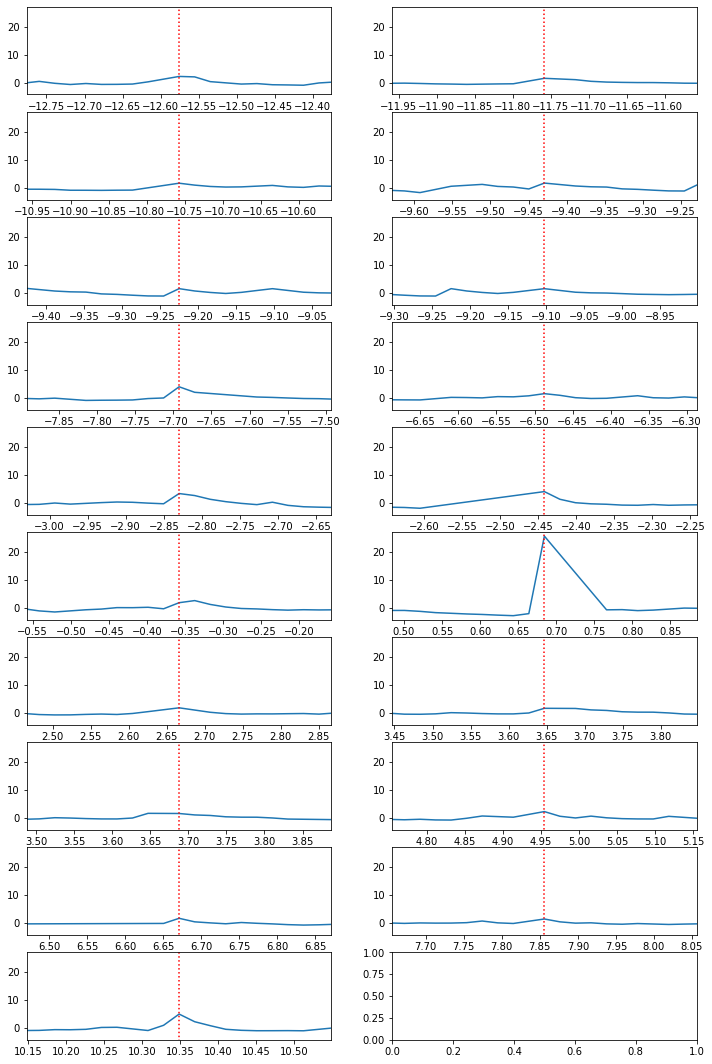

In [130]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks_postgap/2).astype(int), figsize=[12,npeaks_postgap])
axes = axes.flatten()
for i in range(npeaks_postgap):
    ax = axes[i]
    ax.plot(x_postgap, y_postgap)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks_norm_postgap[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks_norm_postgap[i]-0.2, tpeaks_norm_postgap[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

### 8) Flare analysis: xoflares

I've output find_flares() to a csv and will read that in for flare energy and frequency distribution analysis in flare_analysis.ipynb.

### 9) Ancillary plots

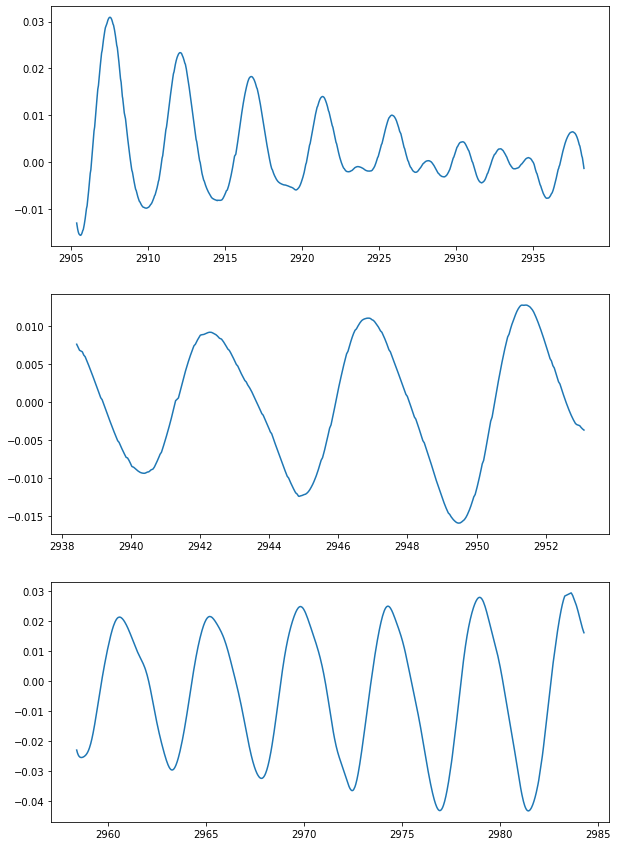

In [172]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, savgol_pre)

plt.subplot(312)
plt.plot(post.TIME, savgol_post)

plt.subplot(313)
plt.plot(postgap.TIME, pred_postgap)
plt.show()

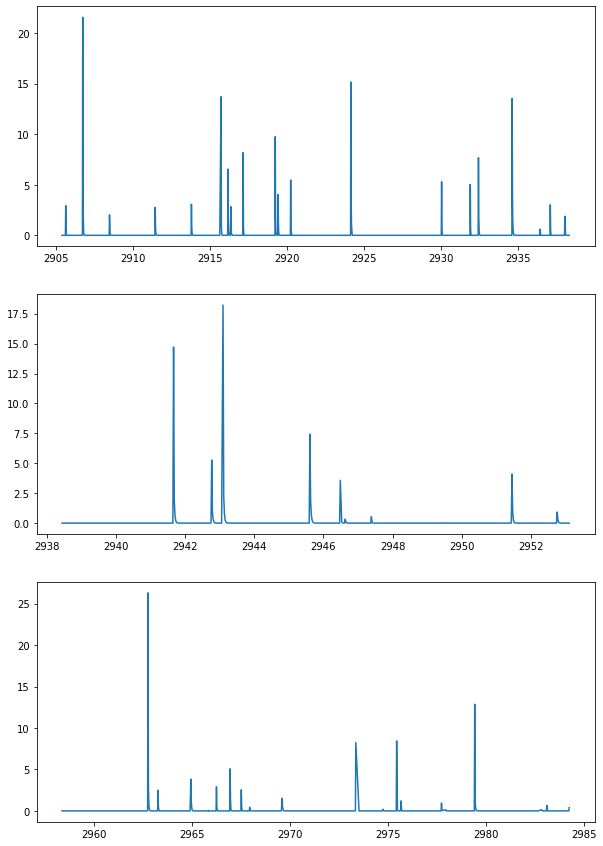

In [173]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(pre.TIME, (flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX))/np.std(flux_pre-pred_pre-pre.PDCSAP_FLUX_ERR/np.median(pre.PDCSAP_FLUX)))

plt.subplot(312)
plt.plot(post.TIME, (flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX))/np.std(flux_post-pred_post-post.PDCSAP_FLUX_ERR/np.median(post.PDCSAP_FLUX)))

plt.subplot(313)
plt.plot(postgap.TIME, (flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX))/np.std(flux_postgap-pred_postgap-postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX)))
plt.show()